In [15]:
import pandas as pd
import numpy as np
import implicit
import nmslib
from scipy.sparse import csr_matrix

from surprise import NMF, KNNBasic, KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import Reader

import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('seaborn-whitegrid')






In [2]:
# dataFolder = 'ml-latest-small'
dataFolder = 'ml-latest-small'
links = pd.read_csv(dataFolder + '/links.csv')
movies = pd.read_csv(dataFolder + '/movies.csv')
ratings = pd.read_csv(dataFolder + '/ratings.csv')
tags = pd.read_csv(dataFolder + '/tags.csv')

In [3]:
# ratings.head()


In [4]:
# movieIds = movies['movieId'].unique()
# numMovies = len(movieIds)
# print('We have {} movies'.format(numMovies))

In [5]:
# userIds = ratings['userId'].unique()
# numUsers = len(userIds)
# print('We have {} users'.format(numUsers))

In [6]:
# movieUserMatrix = np.empty((numMovies, numUsers), dtype=int)
# 
# userIdToUserIndex = {}
# for index, userId in enumerate(userIds):
#     userIdToUserIndex[userId] = index
# 
# movieIdToMovieIndex = {}
# for index, movieId in enumerate(movieIds):
#     movieIdToMovieIndex[movieId] = index
# 
# for row in ratings.iterrows():
#     userId = row[1]['userId']
#     movieId = row[1]['movieId']
#     rating = row[1]['rating']
# 
#     userIndex = int(userIdToUserIndex[userId])
#     movieIndex = int(movieIdToMovieIndex[movieId])
# 
#     movieUserMatrix[movieIndex][userIndex] = int(rating)

In [7]:
# movieUserMatrixSparse = csr_matrix(movieUserMatrix)
# movieUserMatrixSparse

In [8]:
# #Matrix Factorization
# 
# 
# # initialize a model
# modelMatrixFactorization = implicit.als.AlternatingLeastSquares(factors=50)
# 
# # train the model on a sparse matrix of item/user/confidence weights
# modelMatrixFactorization.fit(movieUserMatrixSparse)
# 
# # recommend items for a user
# user_items = movieUserMatrixSparse.T.tocsr()
# userId = 1
# recommendations = modelMatrixFactorization.recommend(userId, user_items)
# 
# # find related items
# movieId = 1
# related = modelMatrixFactorization.similar_items(movieId)


In [9]:
# # Approximate Nearest Neighbors
# 
# 
# # initialize a model
# modelNearestNeighbor = implicit.approximate_als.NMSLibAlternatingLeastSquares()
# 
# # train the model on a sparse matrix of item/user/confidence weights
# modelNearestNeighbor.fit(movieUserMatrixSparse)
# 
# # recommend items for a user
# user_items = movieUserMatrixSparse.T.tocsr()
# userId = 1
# recommendations = modelNearestNeighbor.recommend(userId, user_items)
# 
# # find related items
# movieId = 1
# related = modelNearestNeighbor.similar_items(movieId)
# 


In [10]:
# # find related items
# movieIndex = 0
# 
# 
# def getMovieName(movieIndex):
#     return movies[movies['movieId'] == movieIds[movieIndex]].iloc[0]['title']
# 
# 
# movieName = getMovieName(movieIndex)
# 
# print('Looking at {}'.format(movieName))
# print('')
# 
# relatedMovies = modelMatrixFactorization.similar_items(movieIndex)
# 
# for movieIndex, confidence in relatedMovies:
#     movieName = getMovieName(movieIndex)
#     print('We are {:.0f}% confident that {} is similar'.format(confidence * 100, movieName))

In [11]:
# # find related items
# movieIndex = 0
# 
# 
# def getMovieName(movieIndex):
#     return movies[movies['movieId'] == movieIds[movieIndex]].iloc[0]['title']
# 
# 
# movieName = getMovieName(movieIndex)
# 
# print('Looking at {}'.format(movieName))
# print('')
# 
# relatedMovies = modelNearestNeighbor.similar_items(movieIndex)
# 
# for movieIndex, confidence in relatedMovies:
#     movieName = getMovieName(movieIndex)
#     print('We are {:.0f}% confident that {} is similar'.format(confidence * 100, movieName))

In [12]:
# from annoy import AnnoyIndex
# 
# f = 40
# model = AnnoyIndex(numMovies)  # Length of item vector that will be indexed
#     
# for index, movieRow in enumerate(movieUserMatrix.transpose()):
#     model.add_item(index, movieRow)
# 
# model.build(10) # 10 trees
# model.save('test.ann')
# 
# u = AnnoyIndex(f)
# u.load('test.ann') # super fast, will just mmap the file
# print(u.get_nns_by_item(0, 10)) # will find the 1000 nearest neighbors

In [3]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
ratingsData = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [4]:
def runModel(ratingsData, model, paramGrid):
    
    crossValidationSplits = 5
    gridSearch = GridSearchCV(model, paramGrid, measures=['rmse', 'mae'], cv=crossValidationSplits)
    
    gridSearch.fit(ratingsData)
    
    # best RMSE score
    print('The best RMSE is {}'.format(gridSearch.best_score['rmse']))
    
    # combination of parameters that gave the best RMSE score
    print('The best params are {}'.format(gridSearch.best_params['rmse']))
    
    return gridSearch

In [19]:
model = NMF
paramGrid = {
    'n_epochs': [10, 25, 50], 
    'n_factors': [5, 15, 30],
    'reg_pu': [0.1, 0.3, 0.5],
    'reg_qi': [0.1, 0.3, 0.5],
    'biased': [True, False],
    'random_state': [42],
}
gridSearch = runModel(ratingsData, model, paramGrid)

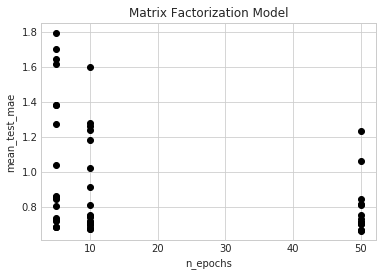

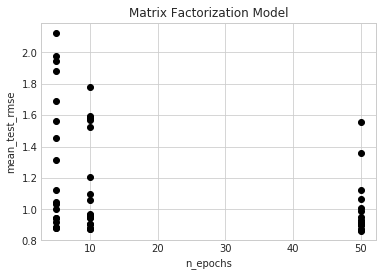

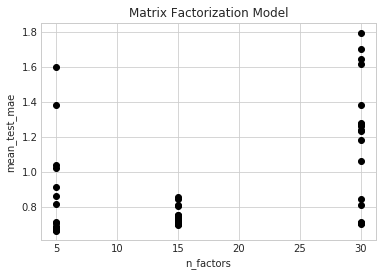

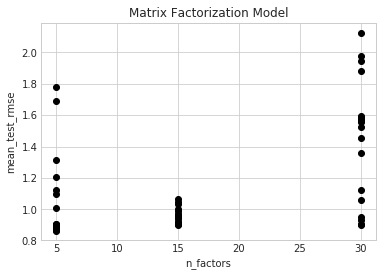

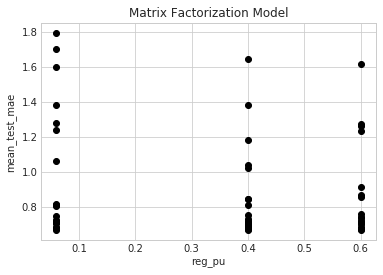

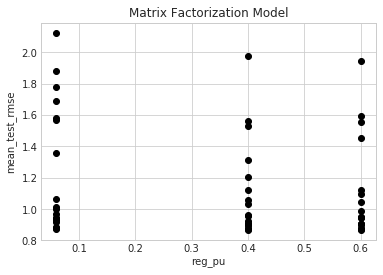

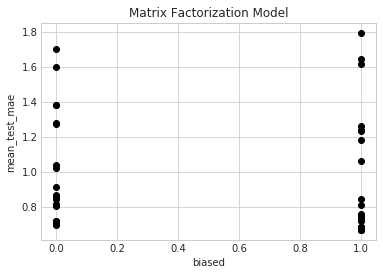

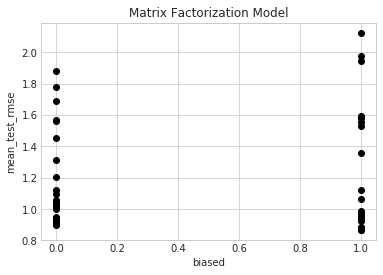

In [ ]:
for param in paramGrid.keys():
    if param == 'random_state':
        continue
    for resultType in ['mean_test_mae', 'mean_test_rmse']:
        x = [result for result in gridSearch.cv_results['param_{}'.format(param)]]
        y = [result for result in gridSearch.cv_results[resultType]]
        
        plt.plot(x, y, 'o', color='black')
        plt.title('Matrix Factorization Model')
        plt.xlabel(param)
        plt.ylabel(resultType)
        plt.show()
        plt.close()

In [22]:
print(gridSearch.cv_results)

{'split0_test_rmse': array([0.93979627, 0.9271889 , 1.92274226, 1.74548046, 0.97516777,
       0.95499049, 1.28998659, 1.08124646]), 'split1_test_rmse': array([0.93631373, 0.92197962, 1.9300968 , 1.74879721, 0.96524045,
       0.95928844, 1.28184158, 1.07640407]), 'split2_test_rmse': array([0.92363522, 0.91874427, 1.9215396 , 1.73859924, 0.95518245,
       0.94384292, 1.27654055, 1.07734103]), 'split3_test_rmse': array([0.91793569, 0.9210884 , 1.9272713 , 1.75102454, 0.96725435,
       0.943302  , 1.27709531, 1.07642315]), 'split4_test_rmse': array([0.92311695, 0.91518562, 1.92260897, 1.74550729, 0.96772138,
       0.94141914, 1.2840903 , 1.07359988]), 'mean_test_rmse': array([0.92815957, 0.92083736, 1.92485179, 1.74588175, 0.96611328,
       0.9485686 , 1.28191087, 1.07700292]), 'std_test_rmse': array([0.00839439, 0.00395052, 0.0032807 , 0.00420201, 0.00642054,
       0.00717411, 0.00493968, 0.00246566]), 'rank_test_rmse': array([2, 1, 8, 7, 4, 3, 6, 5]), 'split0_test_mae': array([0.7

In [16]:
model = KNNWithMeans
paramGrid = {
    'n_epochs': [5, 10], 
    'n_factors': [10, 50],
    'reg_pu': [0.4, 0.6]
}
runModel(ratingsData, model, paramGrid)

Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.
